## DSAI HW1 Peak Load Forecasting

- Description  
請根據台電歷史資料，預測未來七天的"電力尖峰負載"(MW)。

- Evaluation  
a. Goal
預測 2019/4/2 ~ 2019/4/8 的每日"電力尖峰負載"(MW)  
b. Metric
作業將以 “尖峰負載預測值” 與 "尖峰負載實際數值"之 Root-Mean-Squared-Error (RMSE) 作為評估分數。

In [1]:
import numpy as np
import pandas as pd
from keras import backend as K
import keras.models as kModels
import keras.layers as kLayers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\charlychiu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### import data (using 2017[12month], 2018[12month], 2019[1month])

In [2]:
db_data_2017 = pd.read_csv('taipower_2017.csv')[:365]      # 20170101 ~ 20171231  365 records
db_data_2018 = pd.read_csv('taipower_2018.csv')[:365]      # 20180101 ~ 20181231  365 records
db_data_2019 = pd.read_csv('taipower_2019.csv')              # 20190101 ~ 20190330  89 records  ***had been processed

### Data Preprocessing

In [3]:
train_df = db_data_2017.append(db_data_2018)

- Augment Features

In [4]:
def augFeatures(df):
    df["日期"] = pd.to_datetime(df["日期"], format="%Y%m%d")
    df["year"] = df["日期"].dt.year
    df["month"] = df["日期"].dt.month
    df["date"] = df["日期"].dt.day
    df["day"] = df["日期"].dt.dayofweek
    return df

In [5]:
train_df = augFeatures(train_df)
train_df = train_df.append(db_data_2019)

C:\Users\charlychiu\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [6]:
train_df

,date,day,month,year,備轉容量(MW),備轉容量率(%),其他小水力,卓蘭,協和 (#1-#4),南部 (#1-#4),...,通霄 (#1-#6),鉅工,離島,青山,風力發電,馬鞍,麥寮#1,麥寮#2,麥寮#3,龍澗
0,1,6,1,2017,2071.0,9.05,6.2,2.0,71.8,71.4,...,113.5,0.7,10.2,2.0,12.2,0.8,28.1,52.2,57.0,0.6
1,2,0,1,2017,1552.0,6.34,6.0,2.2,70.8,74.5,...,113.6,0.6,10.3,2.6,12.7,0.8,42.6,57.2,57.0,0.7
2,3,1,1,2017,1021.0,3.63,4.0,3.9,73.3,76.1,...,126.0,0.8,10.0,5.5,25.2,2.1,43.0,56.9,57.0,0.4
3,4,2,1,2017,1272.0,4.47,15.9,3.1,73.3,75.9,...,131.7,0.5,10.4,2.5,9.3,1.2,42.8,57.0,57.0,0.4
4,5,3,1,2017,1729.0,6.10,9.3,2.1,72.0,75.9,...,129.8,0.5,10.5,3.0,6.5,0.5,57.2,57.1,57.1,0.3
5,6,4,1,2017,1152.0,4.12,9.2,3.5,71.9,75.8,...,131.3,0.4,10.3,3.0,20.0,0.8,57.1,57.0,57.0,4.2
6,7,5,1,2017,2214.0,8.65,8.4,2.1,71.6,71.6,...,125.8,0.6,10.3,2.5,4.9,0.7,57.2,57.0,57.0,0.6
7,8,6,1,2017,1844.0,7.64,8.1,2.8,100.0,73.4,...,121.6,0.6,7.9,2.6,29.8,0.8,57.2,57.1,57.0,1.1
8,9,0,1,2017,1707.0,6.17,9.2,2.3,114.5,72.8,...,131.9,0.4,7.7,6.0,35.8,0.7,57.1,56.8,57.2,0.0
9,10,1,1,2017,1252.0,4.51,10.3,2.5,114.8,74.5,...,115.2,0.9,10.3,5.0,37.6,1.2,57.2,57.1,57.0,0.7


- Normalization

In [7]:
def normalize(df):
    df = df[['淨尖峰供電能力(MW)','尖峰負載(MW)', '備轉容量(MW)', '備轉容量率(%)', 'month', 'date', 'day']]
    df_norm = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return df_norm

def normalize_with_ref(df, ref_df):
    # tmp_df['尖峰負載(MW)'].describe()['mean']
    df = df[['淨尖峰供電能力(MW)','尖峰負載(MW)', '備轉容量(MW)', '備轉容量率(%)', 'month', 'date', 'day']]
    col_list = ['淨尖峰供電能力(MW)','尖峰負載(MW)', '備轉容量(MW)', '備轉容量率(%)', 'month', 'date', 'day']
    for col in col_list:
        df[col] = (df[col] - ref_df[col].describe()['mean']) / (ref_df[col].describe()['max'] - ref_df[col].describe()['min'])
#     df_norm = df.apply(lambda x: (x - v_mean) / (v_max - v_min))
    return df

In [8]:
tmp_df = train_df
train_df_norm = normalize(tmp_df)[:len(train_df)]

- Convert to training format

In [9]:
def buildTrain(train, pastDay=7, futureDay=7):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["尖峰負載(MW)"]))
    return np.array(X_train), np.array(Y_train)

def buildPredict(train, pastDay=7, futureDay=7):
    X_train = []
    for i in range(train.shape[0]-futureDay+1):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
    return np.array(X_train)

In [10]:
# build Data, use last 7 days to predict next 7 days
X_train, Y_train = buildTrain(train_df_norm, 7, 7)

In [11]:
len(X_train)

805

- Split training, validation

In [12]:
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [13]:
# split training data and validation data
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

In [14]:
# from 2 dimmension to 3 dimension
Y_train = Y_train[:,:,np.newaxis]
Y_val = Y_val[:,:,np.newaxis]

- Define loss function

In [15]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

- Build model (using LSTM)

In [16]:
def buildManyToManyModel(shape):
    model = kModels.Sequential()
    model.add(kLayers.LSTM(10, input_length=shape[1], input_dim=shape[2], return_sequences=True))
    # output shape: (7, 1)
    model.add(kLayers.TimeDistributed(kLayers.Dense(1)))
    model.compile(loss=root_mean_squared_error, optimizer="RMSprop")
    model.summary()
    return model

In [17]:
model = buildManyToManyModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
train_history = model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

C:\Users\charlychiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\charlychiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, return_sequences=True, input_shape=(7, 7))`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 10)             720       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 1)              11        
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________
Train on 725 samples, validate on 80 samples
Epoch 1/1000
725/725 [==============================] - 2s 3ms/step - loss: 0.2029 - val_loss: 0.1636
Epoch 2/1000
725/725 [==============================] - 0s 147us/step - loss: 0.1898 - val_loss: 0.1528
Epoch 3/1000
725/725 [==============================] - 0s 143us/step - loss: 0.1807 - val_loss: 0.1494
Epoch 4/1000
725/725 [==============================] - 0s 142us/step - loss: 0.1729 - val_loss: 0.1433
Epoch 5/1000
725/725 [==============================] - 0s 143us/step - loss: 0.1

725/725 [==============================] - 0s 143us/step - loss: 0.0724 - val_loss: 0.0794
Epoch 74/1000
725/725 [==============================] - 0s 141us/step - loss: 0.0727 - val_loss: 0.0765
Epoch 75/1000
725/725 [==============================] - 0s 146us/step - loss: 0.0722 - val_loss: 0.0746
Epoch 76/1000
725/725 [==============================] - 0s 140us/step - loss: 0.0722 - val_loss: 0.0782
Epoch 77/1000
725/725 [==============================] - 0s 148us/step - loss: 0.0721 - val_loss: 0.0751
Epoch 78/1000
725/725 [==============================] - 0s 143us/step - loss: 0.0720 - val_loss: 0.0732
Epoch 79/1000
725/725 [==============================] - 0s 141us/step - loss: 0.0721 - val_loss: 0.0740
Epoch 80/1000
725/725 [==============================] - 0s 142us/step - loss: 0.0717 - val_loss: 0.0757
Epoch 81/1000
725/725 [==============================] - 0s 140us/step - loss: 0.0719 - val_loss: 0.0742
Epoch 82/1000
725/725 [==============================] - 0s 137us/ste

725/725 [==============================] - 0s 151us/step - loss: 0.0676 - val_loss: 0.0691
Epoch 151/1000
725/725 [==============================] - 0s 136us/step - loss: 0.0676 - val_loss: 0.0709
Epoch 152/1000
725/725 [==============================] - 0s 143us/step - loss: 0.0676 - val_loss: 0.0711
Epoch 153/1000
725/725 [==============================] - 0s 138us/step - loss: 0.0677 - val_loss: 0.0711
Epoch 154/1000
725/725 [==============================] - 0s 182us/step - loss: 0.0677 - val_loss: 0.0702
Epoch 155/1000
725/725 [==============================] - 0s 143us/step - loss: 0.0673 - val_loss: 0.0709
Epoch 156/1000
725/725 [==============================] - 0s 136us/step - loss: 0.0673 - val_loss: 0.0712
Epoch 157/1000
725/725 [==============================] - 0s 139us/step - loss: 0.0673 - val_loss: 0.0712
Epoch 158/1000
725/725 [==============================] - 0s 138us/step - loss: 0.0673 - val_loss: 0.0729
Epoch 159/1000
725/725 [==============================] - 0s 

725/725 [==============================] - 0s 142us/step - loss: 0.0655 - val_loss: 0.0710
Epoch 228/1000
725/725 [==============================] - 0s 137us/step - loss: 0.0655 - val_loss: 0.0712
Epoch 229/1000
725/725 [==============================] - 0s 148us/step - loss: 0.0655 - val_loss: 0.0705
Epoch 230/1000
725/725 [==============================] - 0s 140us/step - loss: 0.0653 - val_loss: 0.0726
Epoch 231/1000
725/725 [==============================] - 0s 139us/step - loss: 0.0654 - val_loss: 0.0726
Epoch 232/1000
725/725 [==============================] - 0s 141us/step - loss: 0.0652 - val_loss: 0.0734
Epoch 233/1000
725/725 [==============================] - ETA: 0s - loss: 0.066 - 0s 133us/step - loss: 0.0655 - val_loss: 0.0684
Epoch 234/1000
725/725 [==============================] - 0s 143us/step - loss: 0.0653 - val_loss: 0.0743
Epoch 235/1000
725/725 [==============================] - 0s 135us/step - loss: 0.0653 - val_loss: 0.0712
Epoch 236/1000
725/725 [=============

725/725 [==============================] - 0s 149us/step - loss: 0.0641 - val_loss: 0.0692
Epoch 305/1000
725/725 [==============================] - 0s 148us/step - loss: 0.0642 - val_loss: 0.0679
Epoch 306/1000
725/725 [==============================] - 0s 147us/step - loss: 0.0641 - val_loss: 0.0791
Epoch 307/1000
725/725 [==============================] - 0s 157us/step - loss: 0.0641 - val_loss: 0.0707
Epoch 308/1000
725/725 [==============================] - 0s 153us/step - loss: 0.0641 - val_loss: 0.0766
Epoch 309/1000
725/725 [==============================] - 0s 152us/step - loss: 0.0642 - val_loss: 0.0710
Epoch 310/1000
725/725 [==============================] - 0s 143us/step - loss: 0.0639 - val_loss: 0.0687
Epoch 311/1000
725/725 [==============================] - 0s 148us/step - loss: 0.0641 - val_loss: 0.0736
Epoch 312/1000
725/725 [==============================] - 0s 148us/step - loss: 0.0642 - val_loss: 0.0670
Epoch 313/1000
725/725 [==============================] - 0s 

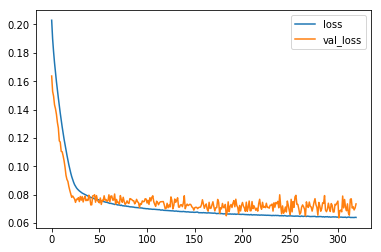

In [18]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()

In [19]:
def denormalized(data):
    return data * (tmp_df['尖峰負載(MW)'].describe()['max'] - tmp_df['尖峰負載(MW)'].describe()['min']) + tmp_df['尖峰負載(MW)'].describe()['mean']

#### 2017 data distribution

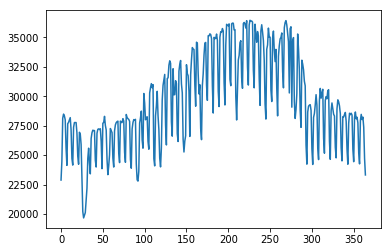

In [20]:
db_data_2017["尖峰負載(MW)"].plot()
plt.show()

#### 2018 data distribution

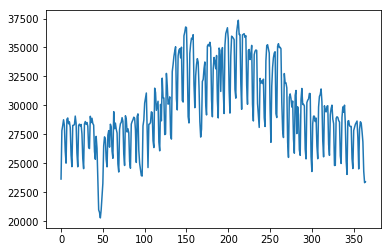

In [21]:
db_data_2018["尖峰負載(MW)"].plot()
plt.show()

#### 2019 data distribution

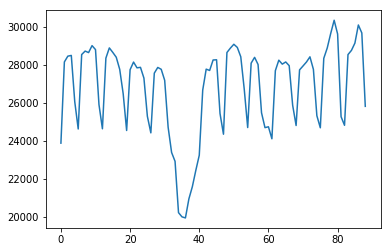

In [22]:
db_data_2019["尖峰負載(MW)"].plot()
plt.show()

### Predict
- Using 7 pastday predict 7 futureday

2019/03/26~2019/04/01 predict 2019/04/02~2019/04/08

In [23]:
db_data_20190326_20190401 = pd.read_csv('taipower_predictData.csv')

In [24]:
db_data_20190326_20190401

,date,尖峰負載(MW),備轉容量(MW),備轉容量率(%),淨尖峰供電能力(MW),日期,year,month,day
0,26,28756,1887,6.56,30643,20190326,2019,3,1
1,27,29140,1933,6.63,31073,20190327,2019,3,2
2,28,30093,1892,6.29,31985,20190328,2019,3,3
3,29,29673,2054,6.92,31727,20190329,2019,3,4
4,30,25810,2155,8.35,27965,20190330,2019,3,5
5,31,24466,2298,9.39,26764,20190331,2019,3,6
6,1,28535,1853,6.49,30388,20190401,2019,4,0


In [25]:
db_data_20190326_20190401 = normalize_with_ref(db_data_20190326_20190401, tmp_df)

C:\Users\charlychiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [26]:
db_data_20190326_20190401

,淨尖峰供電能力(MW),尖峰負載(MW),備轉容量(MW),備轉容量率(%),month,date,day
0,-0.052293,-0.034370,-0.080064,-0.073603,-0.275724,0.343956,-0.333333
1,-0.027577,-0.012649,-0.067875,-0.068680,-0.275724,0.377289,-0.166667
2,0.024842,0.041256,-0.078739,-0.092590,-0.275724,0.410623,0.000000
3,0.010013,0.017499,-0.035814,-0.048286,-0.275724,0.443956,0.166667
4,-0.206219,-0.201008,-0.009052,0.052276,-0.275724,0.477289,0.333333
5,-0.275249,-0.277031,0.028839,0.125413,-0.275724,0.510623,0.500000
6,-0.066950,-0.046871,-0.089073,-0.078525,-0.184815,-0.489377,-0.500000


In [27]:
X_predict = buildPredict(db_data_20190326_20190401)
X_predict

array([[[-0.05229282, -0.03437009, -0.08006403, -0.07360267,
         -0.27572428,  0.34395604, -0.33333333],
        [-0.02757734, -0.0126494 , -0.06787537, -0.06868003,
         -0.27572428,  0.37728938, -0.16666667],
        [ 0.02484248,  0.04125636, -0.07873918, -0.09259002,
         -0.27572428,  0.41062271,  0.        ],
        [ 0.01001319,  0.01749936, -0.0358139 , -0.04828622,
         -0.27572428,  0.44395604,  0.16666667],
        [-0.20621856, -0.20100847, -0.00905184,  0.05227637,
         -0.27572428,  0.47728938,  0.33333333],
        [-0.27524948, -0.27703087,  0.02883899,  0.1254128 ,
         -0.27572428,  0.51062271,  0.5       ],
        [-0.06694968, -0.0468708 , -0.08907304, -0.07852532,
         -0.18481518, -0.48937729, -0.5       ]]])

In [28]:
Y_predict = model.predict(X_predict)

In [29]:
Y_predict = denormalized(Y_predict)

In [30]:
Y_predict

array([[[28989.887],
        [29288.44 ],
        [29866.793],
        [29524.97 ],
        [26319.398],
        [25041.434],
        [28642.877]]], dtype=float32)

*** 四捨五入

### Save to submission.csv

In [31]:
date = ['20190402', '20190403', '20190404', '20190405', '20190406', '20190407', '20190408']
data = []
for idx, v in enumerate(Y_predict[0]):
    print(int(round(v[0], 0)))
    data.append([date[idx], int(round(v[0], 0))])

28990
29288
29867
29525
26319
25041
28643


In [32]:
data

[['20190402', 28990],
 ['20190403', 29288],
 ['20190404', 29867],
 ['20190405', 29525],
 ['20190406', 26319],
 ['20190407', 25041],
 ['20190408', 28643]]

In [33]:
df = pd.DataFrame(data, columns = ['date', 'peak_load(MW)'])
df

,date,peak_load(MW)
0,20190402,28990
1,20190403,29288
2,20190404,29867
3,20190405,29525
4,20190406,26319
5,20190407,25041
6,20190408,28643


In [34]:
df.to_csv('submission.csv', index=0)